# Relative Reconstruction Error

In [1]:
import torch
import pytorch_lightning as pl
import numpy as np
from core.data import GridDataModule
from core.model import AutoEncoder

In [2]:
dm = GridDataModule(data_dir='data/ignition_square',
                    dimension=2,
                    batch_size=1,
                    size=250,
                    stride=250,
                    flatten=False,
                    channels=[1])

trainer = pl.Trainer(accelerator='gpu', devices=1, logger=True)

model = AutoEncoder.load_from_checkpoint('lightning_logs/blanca_ignition_cnn_full_1/checkpoints/epoch=1441-step=64890.ckpt',
                                        input_shape=dm.get_shape())

/home/rs-coop/anaconda3/envs/compression/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [3]:
out = trainer.test(model=model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_err_epoch        0.026428304612636566
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Images/GIFs

In [3]:
import gif
import matplotlib.pyplot as plt

In [4]:
pred = trainer.predict(model=model, datamodule=dm)
pred = dm.agglomerate(pred)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

## Raw data

In [5]:
domain = 'ignition_square'
data_dir = f'data/{domain}/train.npy'

data = torch.from_numpy(np.float32(np.load(data_dir)))
data = data[...,1]

mean = torch.mean(data, dim=(0,1,2), keepdim=True)
stdv = torch.sqrt(torch.var(data, dim=(0,1,2), keepdim=True))
stdv = torch.max(stdv, torch.tensor(1e-3))

data = (data-mean)/stdv

raw = data/(torch.max(np.abs(data))+1e-4)

## Make GIF

In [5]:
@gif.frame
def plot(i):
    fig, ax = plt.subplots(1, 2, figsize=(10,10))
    
    ax[0].imshow(raw[i,:,:], vmin=-1, vmax=1, origin='lower')
    ax[0].set_title("Raw Data")
    
    ax[1].imshow(pred[i,:,:], vmin=-1, vmax=1, origin='lower')
    ax[1].set_title("Reconstructed")

In [10]:
block = [i for i in range(200, 225)]
frames = [plot(i) for i in block]    
gif.save(frames, f'error_spike_{block[0]}_{block[-1]}.gif', duration=100)

## Make Image

Text(0.5, 1.0, 'Reconstructed')

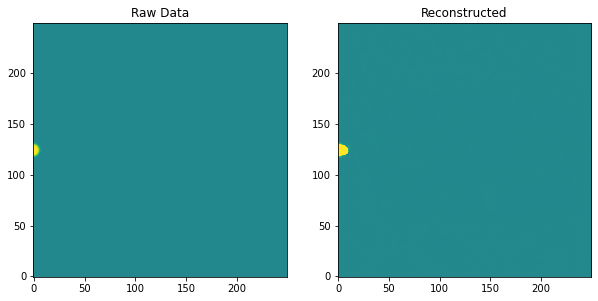

In [39]:
t = 0

fig, ax = plt.subplots(1, 2, figsize=(10,10))
    
ax[0].imshow(raw[t,:,:], vmin=-1, vmax=1, origin='lower')
ax[0].set_title("Raw Data")

ax[1].imshow(pred[t,:,:], vmin=-1, vmax=1, origin='lower')
ax[1].set_title("Reconstructed")

In [40]:
fig.savefig(f"error_{t}.png")